In [414]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dython.nominal import identify_nominal_columns
from geopy import distance

from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from xgboost import XGBRegressor, plot_importance
import xgboost as xgb
import joblib

from utils import preprocess

In [415]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [416]:
DATA_DIR = './data/'
IMG_DIR = './img/'
PROCESSED_DATA_DIR = './processed_data/'
TRAIN_FILE = DATA_DIR + 'train.csv'
TEST_FILE = DATA_DIR + 'test.csv'
PROCESSED_TRAIN_FILE = PROCESSED_DATA_DIR + 'processed_train.csv'
PROCESSED_TEST_FILE = PROCESSED_DATA_DIR + 'processed_test.csv'
AUX_DATA_DIR = DATA_DIR + 'auxiliary-data/'
SUBZONE_FILE = AUX_DATA_DIR + 'sg-subzones.csv'

COMC = AUX_DATA_DIR + 'sg-commerical-centres.csv'
MRT = AUX_DATA_DIR + 'sg-mrt-stations.csv'
PSCHOOL = AUX_DATA_DIR + 'sg-primary-schools.csv'
SSCHOOL = AUX_DATA_DIR + 'sg-secondary-schools.csv'
MALL = AUX_DATA_DIR + 'sg-shopping-malls.csv'

mrt_station = pd.read_csv(MRT)
comc = pd.read_csv(COMC)
pschool = pd.read_csv(PSCHOOL)
sschool = pd.read_csv(SSCHOOL)
mall = pd.read_csv(MALL)

## XGBOOST

## 1 Load preprocessed data

In [397]:
df = pd.read_csv(PROCESSED_TRAIN_FILE)

In [398]:
columns_pa = df.filter(like='pa_').columns
columns_pt = df.filter(like='pt_').columns

In [596]:
df_train = df.copy()

X_train_all = df_train.drop('price', axis=1)
y_train_all = df_train['price']

In [401]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20153 entries, 0 to 20152
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   tenure                          20153 non-null  float64
 1   built_year                      20153 non-null  float64
 2   num_beds                        20153 non-null  float64
 3   num_baths                       20153 non-null  float64
 4   size_sqft                       20153 non-null  float64
 5   lat                             20153 non-null  float64
 6   lng                             20153 non-null  float64
 7   subzone_property_type_encoding  20153 non-null  float64
 8   num_cc_5km                      20153 non-null  int64  
 9   num_mrt_800m                    20153 non-null  int64  
 10  nearest_mrt_km                  20153 non-null  float64
 11  num_ps_1km                      20153 non-null  int64  
 12  num_ps_1km_to_2km               

## 2 model training

### 2.1 intuition to use XGBoost algorithm

In [671]:
X_train, X_test = train_test_split(df_train, test_size=0.2, random_state= 20)

y_train = X_train['price']
X_train.drop('price', axis=1, inplace=True)
y_test = X_test['price']
X_test.drop('price', axis=1, inplace=True)

In [646]:
# create model instance
xgb1 = XGBRegressor(random_state = 20)
# fit model
xgb1.fit(X_train, y_train)
# make predictions
y_hat_train = xgb1.predict(X_train)
y_hat_test = xgb1.predict(X_test)

# Save model into JSON format.
#reg.save_model("regressor.json")

In [647]:
print(
    f' RMSE of XGBoost: \n {mean_squared_error(y_train, y_hat_train, squared=False)} (Train) \
    \n {mean_squared_error(y_test, y_hat_test, squared=False)} (Test)'
)

 RMSE of XGBoost: 
 324646.16548494296 (Train)     
 2190531.9186154464 (Test)


### 2.2 hyper-parameters tuning

* issue: the RMSE between training prediction and validation prediction varies apparently, which refers to a Over-fitting Problem.
* target: improve RMSE of validation set and try to address overfitting problem (trade-off between bias and variance)
    * **colsample_bytree**: Represents the fraction of columns to be randomly sampled for each tree. It might improve overfittin
    * **subsample**: Represents the fraction of observations to be sampled for each tree. A lower values prevent overfitting but might lead to under-fitting.
    * **lambda (Regulation parameter)** : L2 regularization on the weights (Ridge Regression). It might help to reduce overfitting.
    * **feature engineering** : Use planning_area, protery_type, subzone_encoding, auxiliary data or not.


Considering tuning xgboost model for all hyper parameters and feature subsets is time consuing and impractical, our group firstly utilise a **RandomizedSearchCV** method to speed up and grasp the first view of our model and data. Then with RMSE result, we choose a more specific range for hyperparameter tuning and decide what features to use for the following gridsearchCV section.

In [608]:
df_train = df.copy()
# df_train.drop(columns_pa, axis = 1, inplace=True)

X_train_all = df_train.drop('price', axis=1)
y_train_all = df_train['price']

X_train_droppa = df_train.drop(columns_pa, axis = 1).drop('price', axis=1)
y_train_droppa = df_train['price']

In [598]:
def random_search_process(X, y)

    '''
        hyper-parameter tuning randomly is time efficiently to choose the feature input and a rough range of hyper-parameters among 
        hundreds of selection.
    '''
    
    params = { 'max_depth': [3, 5, 10],
               'learning_rate': [0.1, 0.3, 0.5],
               'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1],
               'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1],
               'n_estimators': [50, 100, 500, 1000],
               'reg_lambda': [0, 0.1, 0.3]
             }

    xgbr = xgb.XGBRegressor(random_state= 20)
    kf = KFold(n_splits=5, random_state= 20, shuffle=True)

    reg = RandomizedSearchCV(estimator=xgbr, 
                             param_distributions=params,
                             cv=kf,
                             scoring='neg_mean_squared_error', 
                             n_iter = 60, 
                             n_jobs = 3, 
                             return_train_score=True,
                             verbose=1)

    reg.fit(X, y)
    
    print('input data size:', X.shape)
    print("Best parameters:", reg.best_params_)
    print("Lowest RMSE: ", (-reg.best_score_)**(1/2.0))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
input data size: (20153, 86)
Best parameters: {'subsample': 0.6, 'reg_lambda': 0.3, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.5}
Lowest RMSE:  1657349.277816212


* With the result of **RandomSearchCV**, feature columns without one-hot encoding information of planing area and the entire dataset are two input choises for the further research.

In [628]:
## GridSearchCV to make a exhaustive test for the potential useful combination
def hyper_parameter_selection(X, y):
    params = { 'max_depth': [5],
               'learning_rate': [0.1, 0.3],
               'subsample': [0.6, 0.8, 1],
               'colsample_bytree': [0.6, 0.7, 1],
               'n_estimators': [100, 500],
               'reg_lambda': [0, 0.2]
             }

    xgbr = xgb.XGBRegressor(random_state= 20)
    kf = KFold(n_splits=5, random_state= 20, shuffle=True)

    reg = GridSearchCV(estimator=xgbr, 
                       param_grid=params,
                       cv=kf,
                       n_jobs = 3, 
                       scoring='neg_mean_squared_error', 
                       return_train_score=True,
                       verbose=1)

    reg.fit(X, y)

    #joblib.dump(reg, 'xgb_model.pkl')
    print('input data size:', X.shape)
    print("Best parameters:", reg.best_params_)
    print("training RMSE",  np.sqrt(np.mean(-reg.cv_results_['mean_train_score'])))
    print("Lowest Validation RMSE: ", (-reg.best_score_)**(1/2.0))
    
    return reg

In [709]:
reg_tmp1 = hyper_parameter_selection(X_train_all, y_train_all)
joblib.dump(reg_tmp1, 'xgb_model.pkl')

Fitting 5 folds for each of 72 candidates, totalling 360 fits
input data size: (20153, 86)
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'reg_lambda': 0.2, 'subsample': 0.6}
training RMSE 450655.92043159273
Lowest Validation RMSE:  1686612.6601733211


['xgb_model.pkl']

In [ ]:
reg_tmp2 = hyper_parameter_selection(X_train_droppa, y_train_droppa)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

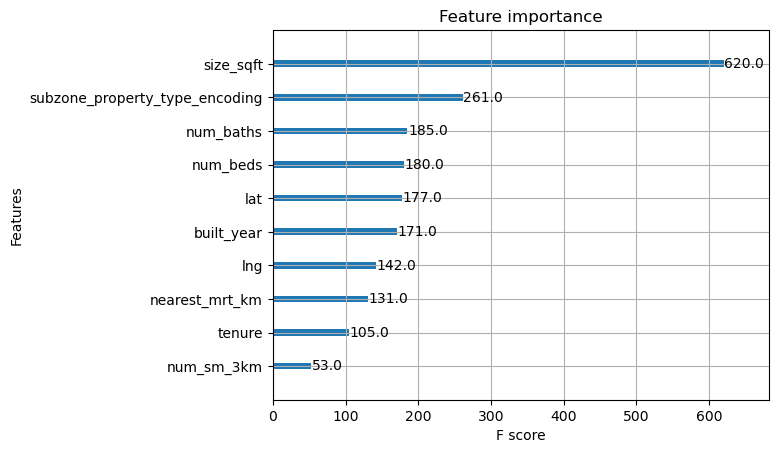

In [612]:
plot_importance(reg_tmp1.best_estimator_, max_num_features= 10)

* Drop feature dimension with only top 10 important features obtained by XGBoost. 
* However, the overall validation rmse increase and it indicates that keeping the entire dataset is better.

In [622]:
target_value = ['size_sqft', 'subzone_property_type_encoding', 'num_baths', 'num_beds', 'lat', 
                'built_year', 'lng', 'nearest_mrt_km', 'tenure', 'num_sm_3km']

X_train_top10 = df_train[target_value]
y_train_top10 = df_train['price']

reg_tmp3 = hyper_parameter_selection(X_train_top10, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
input data size: (20153, 8)
Best parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'reg_lambda': 0, 'subsample': 0.8}
training RMSE 752626.3445848516
Lowest Validation RMSE:  1981369.7339130966


## 3 evaluation
* Evaluate the result of gridsearch and disucss why over-fitting problem is apparent for our data
* Explore and visualize the performance of different hyperparameters suppressing over-fitting issue on this dataset

### 3.1 further research on hyper-parameters

In [588]:
X_eval = df.drop('price', axis=1)
y_eval = df['price']

In [604]:
## subsample ratio
values_ss = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9 ,1.0])

params = { 'max_depth': [5],
           'learning_rate': [0.1],
           'subsample': values_ss,
           'n_estimators': [500],
         }

xgbr = xgb.XGBRegressor(random_state= 20)
kf = KFold(n_splits=5, random_state= 20 , shuffle=True)

reg_subsample = GridSearchCV(estimator=xgbr, 
                             param_grid=params,
                             cv=kf,
                             scoring='neg_mean_squared_error',
                             return_train_score=True,
                             n_jobs= 2,
                             verbose=1)

reg_subsample.fit(X_eval, y_eval)

# joblib.dump(reg_subsample, 'xgb_subsample.pkl')

print("Best parameters:", reg_subsample.best_params_)
print("Lowest RMSE: ", (-reg_subsample.best_score_)**(1/2.0))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.8}
Lowest RMSE:  1653701.5500941635


In [707]:
## colsample_bytree ratio
values_cs = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9 ,1.0])

params = { 'max_depth': [5],
           'learning_rate': [0.1],
           'colsample_bytree': values_cs,
           'n_estimators': [500],
         }

xgbr = xgb.XGBRegressor(random_state= 20)
kf = KFold(n_splits=5, random_state= 20, shuffle=True)

reg_colsample = GridSearchCV(estimator=xgbr, 
                             param_grid=params,
                             cv=kf,
                             scoring='neg_mean_squared_error', 
                             return_train_score=True,
                             n_jobs= 2,
                             verbose=1)

reg_colsample.fit(X_eval, y_eval)

joblib.dump(reg_colsample, 'xgb_colsample.pkl')

print("Best parameters:", reg_colsample.best_params_)
print("Lowest RMSE: ", (-reg_colsample.best_score_)**(1/2.0))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
Lowest RMSE:  1605746.5287007655


In [606]:
## lambda of 2-norm in loss function
values_lambda = np.array([0, 0.1, 0.2, 0.3, 1, 5, 10])

params = { 'max_depth': [5],
           'learning_rate': [0.1],
           'reg_lambda': values_lambda,
           'n_estimators': [500],
         }

xgbr = xgb.XGBRegressor(random_state= 20)
kf = KFold(n_splits=5, random_state= 20, shuffle=True)

reg_lambda = GridSearchCV(estimator=xgbr, 
                          param_grid=params,
                          cv=kf,
                          scoring='neg_mean_squared_error', 
                          return_train_score=True,
                          n_jobs = 2,
                          verbose=1)

reg_lambda.fit(X_eval, y_eval)

# joblib.dump(reg_lambda, 'xgb_lambda.pkl')

print("Best parameters:", reg_lambda.best_params_)
print("Lowest RMSE: ", (-reg_lambda.best_score_)**(1/2.0))

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'reg_lambda': 0.2}
Lowest RMSE:  1584239.608035902


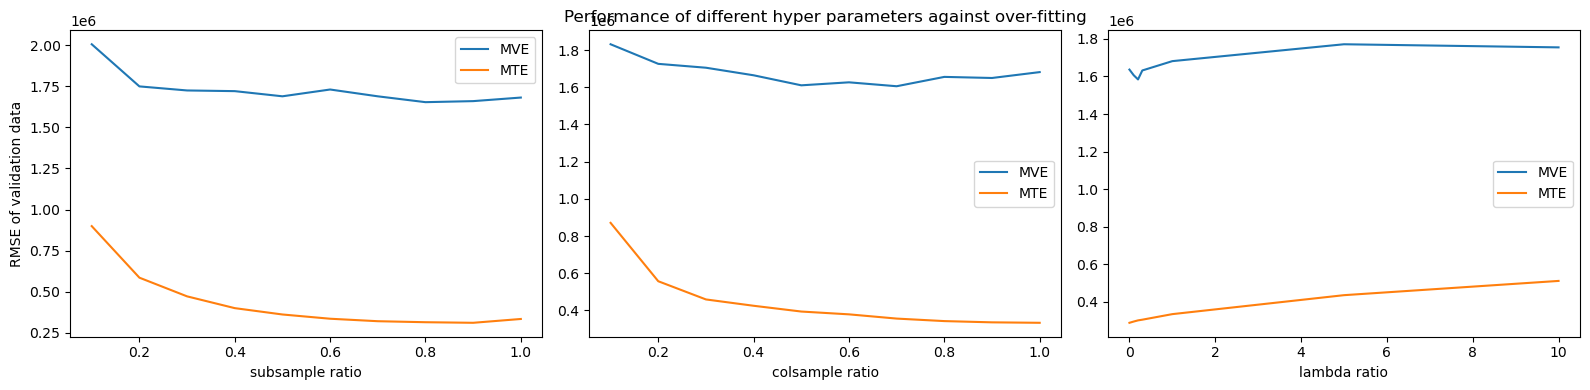

In [627]:
# plot
plt.figure(figsize=(16,4))

ax1=plt.subplot(1,3,1)
ax1.plot(values_ss , (np.sqrt(-reg_subsample.cv_results_['mean_test_score'])), label='MVE')
ax1.plot(values_ss , (np.sqrt(-reg_subsample.cv_results_['mean_train_score'])), label='MTE')
ax1.set_xlabel('subsample ratio')
ax1.set_ylabel("RMSE of validation data")
ax1.legend()

ax1=plt.subplot(1,3,2)
ax1.plot(values_cs , (np.sqrt(-reg_colsample.cv_results_['mean_test_score'])), label='MVE')
ax1.plot(values_cs , (np.sqrt(-reg_colsample.cv_results_['mean_train_score'])), label='MTE')
ax1.set_xlabel('colsample ratio')
ax1.legend()
ax1.set_title("Performance of different hyper parameters against over-fitting")

ax1=plt.subplot(1,3,3)
ax1.plot(values_lambda , (np.sqrt(-reg_lambda.cv_results_['mean_test_score'])), label='MVE')
ax1.plot(values_lambda , (np.sqrt(-reg_lambda.cv_results_['mean_train_score'])), label='MTE')
ax1.set_xlabel('lambda ratio')
ax1.legend()

plt.tight_layout()

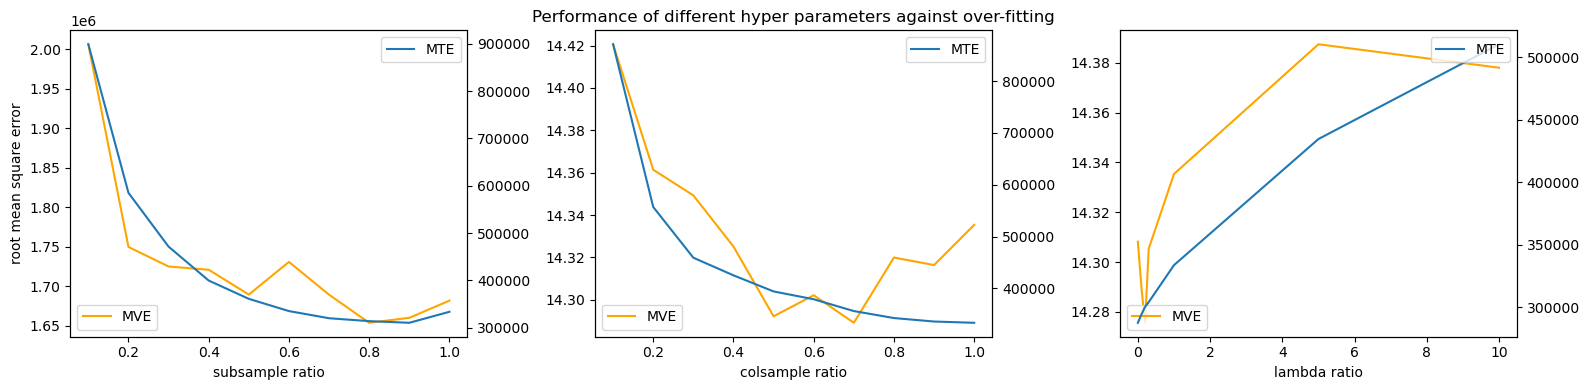

In [607]:
# plot
plt.figure(figsize=(16,4))

ax1=plt.subplot(1,3,1)
ax1.plot(values_ss , (np.sqrt(-reg_subsample.cv_results_['mean_test_score'])), label='MVE', c='orange')
ax1.set_xlabel('subsample ratio')
ax1.set_ylabel('root mean square error')
ax1.legend(loc='lower left')
ax2 = ax1.twinx()
ax2.plot(values_ss , (np.sqrt(-reg_subsample.cv_results_['mean_train_score'])), label='MTE')
ax2.legend()

ax1=plt.subplot(1,3,2)
ax1.plot(values_cs , np.log((np.sqrt(-reg_colsample.cv_results_['mean_test_score']))), label='MVE', c='orange')
ax1.legend(loc='lower left')
ax1.set_xlabel('colsample ratio')
ax2 = ax1.twinx()
ax2.plot(values_cs , (np.sqrt(-reg_colsample.cv_results_['mean_train_score'])), label='MTE')
ax2.legend()
ax1.set_title("Performance of different hyper parameters against over-fitting")

ax1=plt.subplot(1,3,3)
ax1.plot(values_lambda , np.log((np.sqrt(-reg_lambda.cv_results_['mean_test_score']))), label='MVE', c='orange')
ax1.legend(loc ='lower left')
ax1.set_xlabel('lambda ratio')
ax2 = ax1.twinx()
ax2.plot(values_lambda , (np.sqrt(-reg_lambda.cv_results_['mean_train_score'])), label='MTE')
ax2.legend(loc ='upper right')

plt.tight_layout()

### 3.2 result visualization
* Finally, hyper-parameter setting for property resale prices dataset is below:
| Hyper parameter | Value  |
|-----|------------------------------------------------------------------------------------------------------------ |
| Max depth  | 5 |
| Learning rate  | 0.1 | 
| n estimators  | 500 |
| subsample ratio  | 0.8 |
| colsample ratio  | 0.7 |
| reg lambda  | 0.2 |
| input feature | all |

* With **train-test-split** method, our group discover the impact of over-fitting on types of property as well as sale-sqft and plot how bad the prediction is w.r.t these features. 

In [696]:
X_train3, X_test3 = train_test_split(df, test_size=0.2, random_state= 20)

y_train3 = X_train3['price']
X_train3.drop('price', axis=1, inplace=True)
y_test3 = X_test3['price']
X_test3.drop('price', axis=1, inplace=True)

In [697]:
# create model instance
xgb1 = XGBRegressor(n_estimators = 500, max_depth = 5, learning_rate = 0.1, 
                    subsample = 0.8, colsample_bytree = 0.7, reg_lambda = 0.2,
                    )
# fit model
xgb1.fit(X_train3, y_train3)
# make predictions
y_hat_train = xgb1.predict(X_train3)
y_hat_test = xgb1.predict(X_test3)

# record error
X_test3['price'] = y_test3
X_test3['prediction'] = y_hat_test
X_test3['scaled_error'] = np.abs((y_hat_test - y_test3) / y_test3)

In [698]:
print(
    f' RMSE of Adaboost: \n {mean_squared_error(y_train3, y_hat_train, squared=False)} (Train) \
    \n {mean_squared_error(y_test3, y_hat_test, squared=False)} (Test)'
)

 RMSE of Adaboost: 
 318301.5867949501 (Train)     
 1985435.5558888512 (Test)


Improvement: After hyper-parameters tuning, the RMSE of validation (random state = 20) drop 10% from 2,190,000 

#### plot the difference between ground truth and prediction for both training and test data

/Users/apple/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/apple/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Test set')

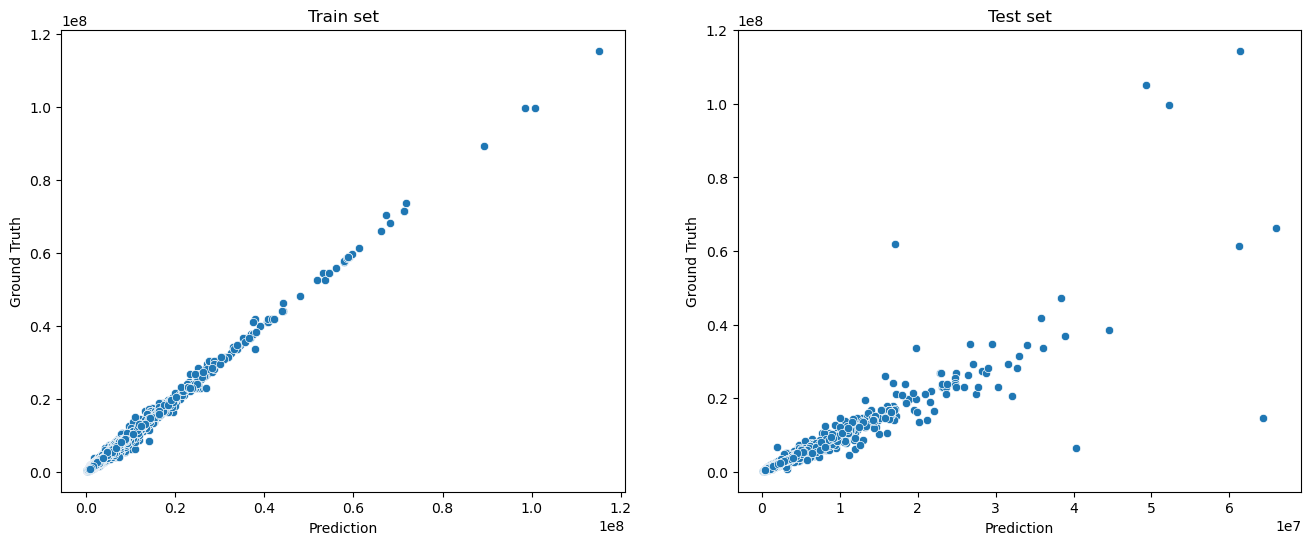

In [699]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.scatterplot(y_hat_train, y_train3, ax=ax[0])
sns.scatterplot(y_hat_test, y_test3, ax=ax[1])
ax[0].set_xlabel('Prediction')
ax[0].set_ylabel('Ground Truth')

ax[1].set_xlabel('Prediction')
ax[1].set_ylabel('Ground Truth')

ax[0].set_title('Train set')
ax[1].set_title('Test set')

#### plot scaled error w.r.t sale_sqft

Text(0.5, 1.0, 'prediction deviation for different sale_sqft')

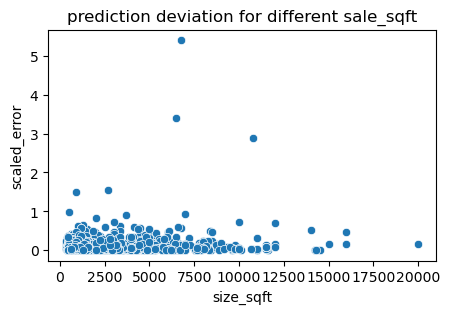

In [700]:
plt.figure(figsize=(5,3))
sns.scatterplot(data = X_test3, x = 'size_sqft', y='scaled_error')
plt.title("prediction deviation for different sale_sqft")

In [701]:
# prediction outliers
X_test3.loc[X_test3['scaled_error']>1, :]

,tenure,built_year,num_beds,num_baths,size_sqft,lat,lng,subzone_property_type_encoding,num_cc_5km,num_mrt_800m,...,pt_land_only,pt_landed,pt_semi-detached_house,pt_shophouse,pt_terraced_house,pt_townhouse,pt_walk-up,price,prediction,scaled_error
20060,2.0,4.0,5.0,4.0,6774.0,1.321909,103.791291,4911.376033,8,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6300000.0,40377580.00,5.409140
4142,0.0,4.0,3.0,2.0,10774.0,1.324910,103.855593,694.281976,7,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,848400.0,3289607.25,2.877425
14200,2.0,3.0,4.0,3.0,2700.0,1.359000,103.880536,2820.895522,7,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4410000.0,11237044.00,1.548083
7740,2.0,4.0,5.0,4.0,6469.0,1.317900,103.825862,6743.830103,8,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14626500.0,64271372.00,3.394173
7146,2.0,4.0,2.0,2.0,893.0,1.420322,103.718184,1399.216125,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1249500.0,3102806.75,1.483239


#### plot scaled error w.r.t location

Text(0.5, 1.0, 'prediction deviation for different location')

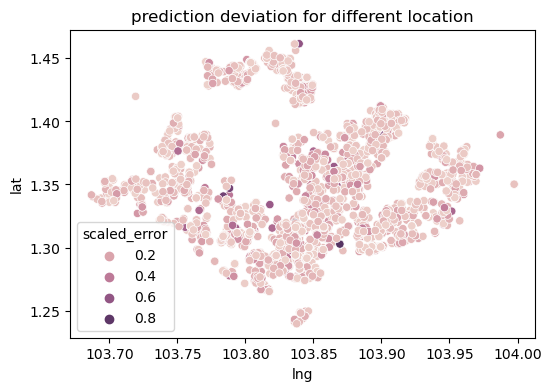

In [706]:
plt.figure(figsize=(6,4))
sns.scatterplot(data = X_test3.loc[X_test3['scaled_error']<=1, :], x = 'lng', y='lat', hue='scaled_error')
plt.title("prediction deviation for different location")

## 4 prediction

In [424]:
test_set = pd.read_csv(PROCESSED_TEST_FILE)

# features_drop = ['lat', 'lng', 'nearest_mrt_km']

df_test = test_set.copy()

df_test.drop(columns_pa, axis=1, inplace=True)
# df_test.drop(columns_pt, axis=1, inplace=True)

model = joblib.load('xgb_model.pkl')

output = pd.read_csv('./example-submission.csv')
output["Predicted"] = model.predict(df_test)
output.to_csv('xgb_submission1.csv', index=False)

In [618]:
## return test prediction with models in the evaluation part
test_set = pd.read_csv(PROCESSED_TEST_FILE)
df_test2 = test_set[target_value]

model = joblib.load('xgb_colsample.pkl')

output = pd.read_csv('./example-submission.csv')
output["Predicted"] = model.predict(df_test2)
output.to_csv('xgb_submission2.csv', index=False)